# Flux Partitioning with uncertainty prediction

This notebook aims at providing an uncertainty estimation for the flux partitioning problem, using Bayesian Neural Networks.
Thanks to Mohamed Aziz Bhouri for his help with Bayesian modeling and the HMC fine-tuning, and to Weiwei Zhan for her flux partitioning NN model and her data.

## Initialization and pre-training

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tqdm import tqdm

from HMC import HMC
from flux_preprocessing import load_dataset
from flux_utils import get_layer_model, fluxes_SIF_predict_noSIF, count_out_distribution
from flux_viz import quad_viz

%matplotlib inline
plt.rcParams["legend.frameon"] = False
plt.rcParams['savefig.dpi'] = 310
plt.rcParams['font.size'] = 13
data_dir = Path("../data")

tf.random.set_seed(0)

hidden_dim = 32

Let's first preprocess the data set. This notebook currently uses simulated data with added noise.

In [2]:
train, test, EV1_train1, EV2_train1, NEE_train1, label_train, EV1_test1, EV2_test1, NEE_test1, label_test, NEE_max_abs = load_dataset(
    'NNinput_SCOPE_US_Ha1_1314.csv')

2022-04-04 19:30:06.826292: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-04 19:30:07.280453: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3794 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1660 Ti, pci bus id: 0000:2b:00.0, compute capability: 7.5


These are both the training and testing sets. A 70-30 split is done chronologically, to avoid both our sets to be highly correlated.

In [3]:
train.head()

,Tair,Tsoil,T_leaf,T_canopy,RH,ea,u,fesc,fesc1,LAI,...,SIFcanopy_760nm,LUE_canopy,SIFyield_canopy,Date,Time,APAR_label,NEE_night,SIF_obs,NEE_obs,train_label
2013-06-19 00:00:00,12.6,18.77,14.49,12.74,94.50072,13.847,1.4,0.0,0.0,4.221,...,0.0000,0.0,0.0,2013-06-19,00:00:00,0,3.327953,0.0000,4.062361,Training set
2013-06-19 01:00:00,12.3,17.72,13.87,12.19,95.70137,13.746,1.5,0.0,0.0,4.221,...,0.0000,0.0,0.0,2013-06-19,01:00:00,0,3.327953,0.0000,3.681533,Training set
2013-06-19 02:00:00,11.9,16.87,13.05,11.63,93.79667,13.118,2.0,0.0,0.0,4.221,...,0.0000,0.0,0.0,2013-06-19,02:00:00,0,3.327953,0.0000,3.323355,Training set
2013-06-19 03:00:00,11.3,16.13,12.35,11.04,92.09961,12.374,2.3,0.0,0.0,4.221,...,0.0000,0.0,0.0,2013-06-19,03:00:00,0,3.327953,0.0000,3.450334,Training set
2013-06-19 04:00:00,11.2,15.43,12.33,10.98,88.10334,11.758,3.0,0.0,0.0,4.221,...,0.0093,0.0,0.0,2013-06-19,04:00:00,0,3.327953,0.0093,2.939732,Training set


In [4]:
test.head()

,Tair,Tsoil,T_leaf,T_canopy,RH,ea,u,fesc,fesc1,LAI,...,SIFcanopy_760nm,LUE_canopy,SIFyield_canopy,Date,Time,APAR_label,NEE_night,SIF_obs,NEE_obs,train_label
2014-07-30 02:00:00,14.1,16.68,16.02,14.06,95.102810,15.387,1.2,0.000000,0.000000,3.955,...,0.0000,0.000000,0.000000,2014-07-30,02:00:00,0,2.930302,0.000000,3.656422,Test set
2014-07-30 03:00:00,14.2,16.69,16.36,14.11,96.401980,15.700,0.9,0.000000,0.000000,3.955,...,0.0000,0.000000,0.000000,2014-07-30,03:00:00,0,2.930302,0.000000,3.237207,Test set
2014-07-30 04:00:00,13.9,16.54,15.90,13.86,96.099170,15.345,1.1,0.000000,0.000000,3.955,...,0.0000,0.000000,0.000000,2014-07-30,04:00:00,0,2.930302,0.000000,2.939725,Test set
2014-07-30 05:00:00,14.2,16.48,16.98,14.19,96.101105,15.651,1.2,0.000000,0.000000,3.955,...,0.0290,0.000000,0.000000,2014-07-30,05:00:00,0,2.930302,0.029000,2.004546,Test set
2014-07-30 07:00:00,16.9,17.26,20.07,17.89,82.498240,16.016,0.3,0.386452,0.429911,3.955,...,0.4536,0.033081,0.001314,2014-07-30,07:00:00,1,2.930302,0.323642,-7.951776,Test set


Let's now define an NN model to predict both Gross Primary Product (GPP) and Respiration (Reco) from the NEE observations. This model has 2 branches, one for each flux, which are then combined to predict the NEE.

In [5]:
def NN_noSIF(n_neuron, activation1, activation2):
    # GPP
    APAR_input = Input(shape=(1,), dtype='float32', name='APAR_input')
    EV_input1 = Input(shape=(EV1_train1.shape[1],), dtype='float32', name='EV_input1')
    x = Dense(n_neuron, activation=activation1, name='hidden1_1')(EV_input1)
    # x = Dense(n_neuron, activation=activation2, name='hidden1_2')(x)
    ln_GPP = Dense(1, activation=None, name='ln_GPP')(x)
    GPP_1 = Lambda(lambda x: K.exp(x), name='GPP_1')(ln_GPP)
    GPP = keras.layers.Multiply(name='GPP')([GPP_1, APAR_input])

    # Reco
    EV_input2 = Input(shape=(EV2_train1.shape[1],), dtype='float32', name='EV_input2')
    x = Dense(n_neuron, activation=activation1, name='hidden2_1')(EV_input2)
    x = Dense(n_neuron, activation=activation2, name='hidden2_2')(x)
    ln_Reco = Dense(1, activation=None, name='ln_Reco')(x)
    Reco = Lambda(lambda x: K.exp(x), name='Reco')(ln_Reco)

    NEE = keras.layers.Subtract(name='NEE')([Reco, GPP])

    model_NEE = Model(inputs=[APAR_input, EV_input1, EV_input2], outputs=[NEE])
    model_NEE.compile(
        optimizer=keras.optimizers.Adam(5e-3),
        loss=keras.losses.MeanSquaredError()
    )

    return model_NEE

The training is relatively fast (a few seconds on my setup). We can check that the model is able to predict NEE correctly.

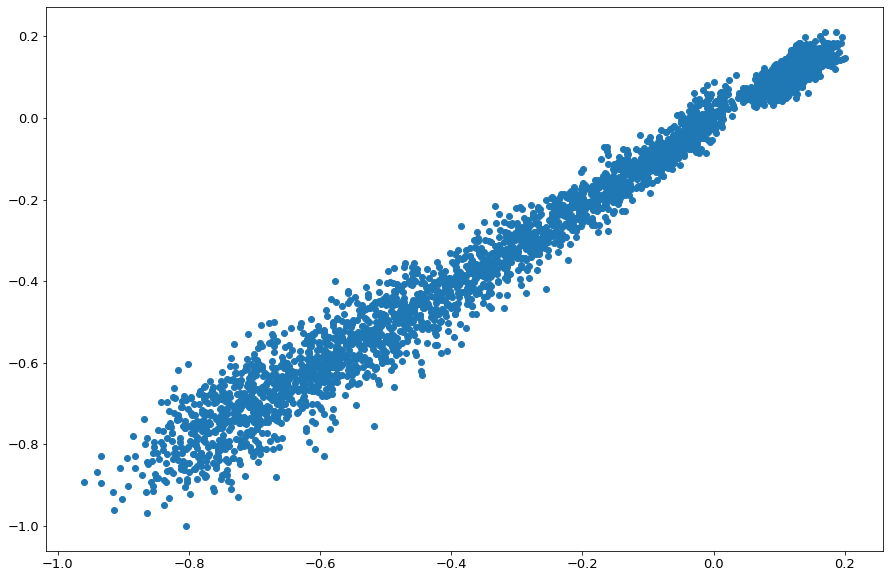

Model initial training loss = 1.756e-03 and testing loss = 2.139e-03


In [6]:
earlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto')
model1 = NN_noSIF(n_neuron=hidden_dim, activation1='relu', activation2='relu')
hist_noSIF = model1.fit({'APAR_input': label_train, 'EV_input1': EV1_train1, 'EV_input2': EV2_train1},
                             NEE_train1,
                             epochs=500,
                             batch_size=64,
                             callbacks=[earlyStopping],
                             validation_split=0.3,
                             verbose=0)

pred_train = model1({'APAR_input': label_train, 'EV_input1': EV1_train1, 'EV_input2': EV2_train1})
plt.figure(figsize=(15,10))
plt.scatter(pred_train, NEE_train1)
plt.show()
train_loss = model1.loss(pred_train, NEE_train1)

pred_test = model1({'APAR_input': label_test, 'EV_input1': EV1_test1, 'EV_input2': EV2_test1})
test_loss = model1.loss(pred_test, NEE_test1)

print("Model initial training loss = {train_loss:.3e} and testing loss = {test_loss:.3e}".format(train_loss = train_loss, test_loss=test_loss))

Here is a brief overview of the model that we are using. Depending on the specifications provided in the above function, the number  of trainable parameters is in the $10^3:10^4$ range.

In [7]:
model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 EV_input2 (InputLayer)         [(None, 4)]          0           []                               
                                                                                                  
 EV_input1 (InputLayer)         [(None, 6)]          0           []                               
                                                                                                  
 hidden2_1 (Dense)              (None, 32)           160         ['EV_input2[0][0]']              
                                                                                                  
 hidden1_1 (Dense)              (None, 32)           224         ['EV_input1[0][0]']              
                                                                                              

## HMC run

Then, we proceed to the HMC random walk to sample values for the parameters. Here are a few observations worth noticing that I realized during my fine-tuning:

- Compared to the NODE-HMC framework, `epsilon` has to be increased significantly to enable a proper search ($\sim \times 10$);
- When the number of parameters of the model increases, `epsilon` has to be slightly reduced to avoid numerical instabilities, but more importantly `L` has to be significantly increased ($\sim\times 10$). Otherwise, the HMC would be unable to conduct a proper exploration for $\log(\lambda)$;
- When these conditions are met, HMC exploration is surprisingly fast  (> 10 samples/sec), with a high acceptance rate, and usually passes the diagnostics;

In [8]:
burn_in = 1000
n_iter = 2000

n_obs_train = NEE_train1.shape[0]
n_obs_test = NEE_test1.shape[0]


def sample(model, inputs):
    # Create HMC super-model
    n_obs = inputs[1].shape[0]
    hmc = HMC(model, L=100, epsilon_min=2e-3, epsilon_max=2e-3, batch_size=n_obs, n_obs=n_obs)

    # Initialize bookkeeping
    parameters = []  # bookkeeping the parameters
    log_gamma = []  # bookkeeping the loggamma
    log_lambda = []  # bookkeeping the loggamma
    log_likelihood = []  # bookkeeping the loggamma
    hamiltonians = []
    acceptance = []

    # training loop
    hmc.init_parameters(inputs)
    for step in tqdm(range(n_iter + burn_in)):
        new_state, loss, p, accepted, h = hmc(inputs, tf.constant(step, dtype=tf.float32),
                                              tf.constant(n_iter, dtype=tf.float32))

        # bookkeeping
        if step > burn_in:
            parameters.append(new_state.position)
            log_gamma.append(new_state.log_gamma)
            log_lambda.append(new_state.log_lambda)
            log_likelihood.append(loss)
            acceptance.append(accepted)
            hamiltonians.append(h)

    parameters = tf.stack(parameters, axis=0).numpy()
    log_gamma = tf.concat(log_gamma, axis=0).numpy()
    log_lambda = tf.concat(log_lambda, axis=0).numpy()
    log_likelihood = tf.concat(log_likelihood, axis=0).numpy()
    hamiltonians = tf.concat(hamiltonians, axis=0).numpy()
    acceptance = np.array(acceptance)
    print(f"Sampling done: {n_iter} steps with accepting rate {np.mean(acceptance)}")
    return hmc, parameters, log_gamma, log_lambda, log_likelihood, hamiltonians, acceptance

In [9]:
hmc, parameters, log_gamma, log_lambda, log_likelihood, hamiltonians, acceptance = sample(model1, (
    {'APAR_input': label_train, 'EV_input1': EV1_train1, 'EV_input2': EV2_train1}, NEE_train1))

100%|██████████| 3000/3000 [04:01<00:00, 12.44it/s]

Sampling done: 2000 steps with accepting rate 0.9329664832416208


Now that the random walk is done, let's check on the MAP estimate, and compare the results with the recorded loss (to make sure there hasn't been any mix-up).

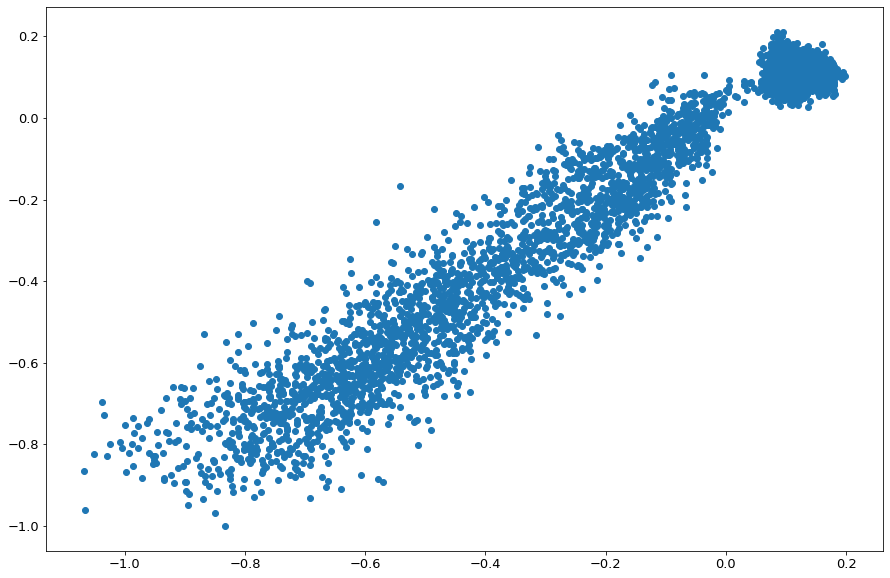

MAP training loss = 5.177e-03 and testing loss = 4.558e-03
Recorded MAP training loss = 5.177e-03


In [10]:
# Computing MAP estimate
idx_MAP = np.argmin(log_likelihood)
MAP = tf.constant(parameters[idx_MAP, :], dtype=tf.float32)
hmc.set_model_params(MAP)
NEE_train_MAP, GPP_train_MAP, Reco_train_MAP = fluxes_SIF_predict_noSIF(hmc.model, label_train, EV1_train1, EV2_train1,
                                                                        NEE_max_abs)
NEE_test_MAP, GPP_test_MAP, Reco_test_MAP = fluxes_SIF_predict_noSIF(hmc.model, label_test, EV1_test1, EV2_test1,
                                                                     NEE_max_abs)

train_pred = hmc.model({'APAR_input': label_train, 'EV_input1': EV1_train1, 'EV_input2': EV2_train1})
train_loss = hmc.model.loss(train_pred, NEE_train1)
plt.figure(figsize=(15,10))
plt.scatter(train_pred, NEE_train1)
plt.show()

test_pred = hmc.model({'APAR_input': label_test, 'EV_input1': EV1_test1, 'EV_input2': EV2_test1})
test_loss = hmc.model.loss(test_pred, NEE_test1)
print("MAP training loss = {train_loss:.3e} and testing loss = {test_loss:.3e}".format(train_loss = train_loss, test_loss=test_loss))
print("Recorded MAP training loss = {loss:.3e}".format(loss=np.min(log_likelihood)))

The MAP estimate is slightly worse than the pre-trained model. In my opinion this is due to the Bayesian modeling enforcing a too high sparsity,when it is not the case in the standard NN model. I will discuss this further at the end.

## HMC sampling

Now that we have our random walk, let's sample from it and compute the mean and deviation of our predictions.

In [11]:
# preparing sampling
precision = np.exp(log_gamma)
n_samples = int(n_iter/2)
NEE_train_traj, GPP_train_traj, Reco_train_traj = np.zeros((n_obs_train, n_samples)), np.zeros(
    (n_obs_train, n_samples)), np.zeros(
    (n_obs_train, n_samples))
NEE_test_traj, GPP_test_traj, Reco_test_traj = np.zeros((n_obs_test, n_samples)), np.zeros(
    (n_obs_test, n_samples)), np.zeros(
    (n_obs_test, n_samples))
sigma_NEE = np.std(train["NEE_canopy"])
sigma_GPP = np.std(train["GPP_canopy"])
sigma_Reco = np.std(train["Reco_canopy"])

# sampling
model_NEE = get_layer_model(hmc.model, "NEE")
model_GPP = get_layer_model(hmc.model, "GPP")
model_Reco = get_layer_model(hmc.model, "Reco")
for k in tqdm(range(n_samples)):
    idx_1 = np.random.randint(0, n_iter - 1)
    idx_2 = np.random.randint(0, n_iter - 1)
    w_sample = parameters[-idx_1, :]
    precision_here = precision[-idx_2]
    hmc.set_model_params(w_sample)

    NEE_train_traj[:, k] = NEE_max_abs * tf.squeeze(model_NEE({'APAR_input': label_train,
                                                               'EV_input1': EV1_train1,
                                                               'EV_input2': EV2_train1})) + sigma_NEE * np.random.normal() / np.sqrt(
        precision_here)
    GPP_train_traj[:, k] = NEE_max_abs * tf.squeeze(model_GPP({'APAR_input': label_train,
                                                               'EV_input1': EV1_train1,
                                                               'EV_input2': EV2_train1})) + sigma_GPP * np.random.normal() / np.sqrt(
        precision_here)
    Reco_train_traj[:, k] = NEE_max_abs * tf.squeeze(model_Reco({'APAR_input': label_train,
                                                                 'EV_input1': EV1_train1,
                                                                 'EV_input2': EV2_train1})) + sigma_Reco * np.random.normal() / np.sqrt(
        precision_here)

    NEE_test_traj[:, k] = NEE_max_abs * tf.squeeze(model_NEE({'APAR_input': label_test,
                                                              'EV_input1': EV1_test1,
                                                              'EV_input2': EV2_test1})) + sigma_NEE * np.random.normal() / np.sqrt(
        precision_here)
    GPP_test_traj[:, k] = NEE_max_abs * tf.squeeze(model_GPP({'APAR_input': label_test,
                                                              'EV_input1': EV1_test1,
                                                              'EV_input2': EV2_test1})) + sigma_GPP * np.random.normal() / np.sqrt(
        precision_here)
    Reco_test_traj[:, k] = NEE_max_abs * tf.squeeze(model_Reco({'APAR_input': label_test,
                                                                'EV_input1': EV1_test1,
                                                                'EV_input2': EV2_test1})) + sigma_Reco * np.random.normal() / np.sqrt(
        precision_here)

mu_NEE_pred_train = np.mean(NEE_train_traj, axis=1)
mu_GPP_pred_train = np.mean(GPP_train_traj, axis=1)
mu_Reco_pred_train = np.mean(Reco_train_traj, axis=1)

sigma_NEE_pred_train = np.std(NEE_train_traj, axis=1)
sigma_GPP_pred_train = np.std(GPP_train_traj, axis=1)
sigma_Reco_pred_train = np.std(Reco_train_traj, axis=1)

mu_NEE_pred_test = np.mean(NEE_test_traj, axis=1)
mu_GPP_pred_test = np.mean(GPP_test_traj, axis=1)
mu_Reco_pred_test = np.mean(Reco_test_traj, axis=1)

sigma_NEE_pred_test = np.std(NEE_test_traj, axis=1)
sigma_GPP_pred_test = np.std(GPP_test_traj, axis=1)
sigma_Reco_pred_test = np.std(Reco_test_traj, axis=1)

100%|██████████| 1000/1000 [00:11<00:00, 87.42it/s]


## Diagnostics

I run some diagnostics here (mostly auto-correlation). A more complete set of diagnostics is conducted in the corresponding R notebook.
The first step is to conduct a second HMC walk, with a different initialization, to check on the convergence.

In [12]:
# Diagnostic and logs
dir = Path("../etc/diagnostic/flux_nn")
dir.mkdir(exist_ok=True)

model2 = NN_noSIF(n_neuron=hidden_dim, activation1='relu', activation2='relu')
model2.fit({'APAR_input': label_train, 'EV_input1': EV1_train1, 'EV_input2': EV2_train1},
                             {'NEE': NEE_train1},
                             epochs=500,
                             batch_size=64,
                             callbacks=[earlyStopping],
                             validation_split=0.3,
                             verbose=0)
_, parameters2, log_gamma2, log_lambda2, log_likelihood2, hamiltonians2, acceptance2 = sample(model2, (
    {'APAR_input': label_train, 'EV_input1': EV1_train1, 'EV_input2': EV2_train1}, NEE_train1))

100%|██████████| 3000/3000 [04:06<00:00, 12.18it/s]

Sampling done: 2000 steps with accepting rate 0.9369684842421211


Both our runs are then saved to be processed in the R notebook (4 random parameters are sampled out of the thousands that are used).

In [13]:
np.save(dir / "log_gamma.npy", np.stack([log_gamma, log_gamma2], axis=1).astype(np.float64))
np.save(dir / "log_lambda.npy", np.stack([log_lambda, log_lambda2], axis=1).astype(np.float64))
tmp = np.stack([parameters, parameters2], axis=2).astype(np.float64)
for i in range(4):
    random_param = np.random.randint(0, parameters.shape[1])
    np.save(dir / ("parameter" + str(i) + ".npy"), tmp[:,random_param,:])
np.save(dir / "full_parameters.npy", tmp)

Let's then check with 16 random parameters that the auto-correlation plot doesn't show any symptomatic behavior.

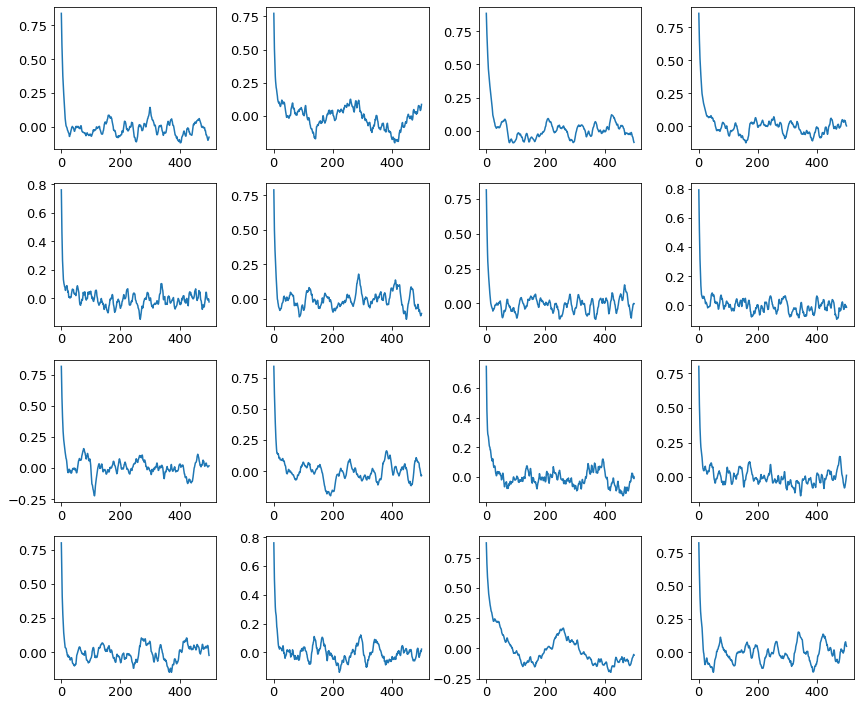

In [14]:
# plot auto-correlation

fig, axs = plt.subplots(4, 4, figsize=(12, 10))
axs = axs.flatten()
max_lag = int(n_iter/4)
for k in range(len(axs)):
    i = np.random.randint(0, parameters.shape[1])
    auto_cor = []
    mean = np.mean(parameters[:, i])
    var = np.var(parameters[:, i])
    for lag in range(1, max_lag):
        param = parameters[lag:, i]
        param_lagged = parameters[:-lag, i]
        auto_cor.append(np.mean((param - mean) * (param_lagged - mean)) / var)
    axs[k].plot(np.arange(1, max_lag), auto_cor)
plt.tight_layout()
plt.show()

We conduct the same operation with $\log(\gamma)$ and $\log(\lambda)$. These are more prone to show high-correlation, especially $\log(\lambda)$, as explained earlier. If that's the case, I would suggest to slightly increase `epsilon` as long as the acceptance rate doesn't drop, and then increase `L`.

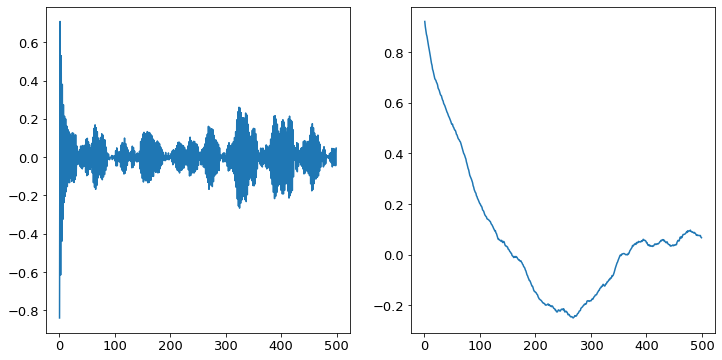

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs = axs.flatten()

mean = np.mean(log_gamma)
var = np.var(log_gamma)
auto_cor = []
for lag in range(1, max_lag):
    param = log_gamma[lag:]
    param_lagged = log_gamma[:-lag]
    auto_cor.append(np.mean((param - mean) * (param_lagged - mean)) / var)
axs[0].plot(np.arange(1, max_lag), auto_cor)

mean = np.mean(log_lambda)
var = np.var(log_lambda)
auto_cor = []
for lag in range(1, max_lag):
    param = log_lambda[lag:]
    param_lagged = log_lambda[:-lag]
    auto_cor.append(np.mean((param - mean) * (param_lagged - mean)) / var)
axs[1].plot(np.arange(1, max_lag), auto_cor)
plt.show()

We can also have a look at the parameter spread and correlation. It should be close to a centered gaussian in most cases.

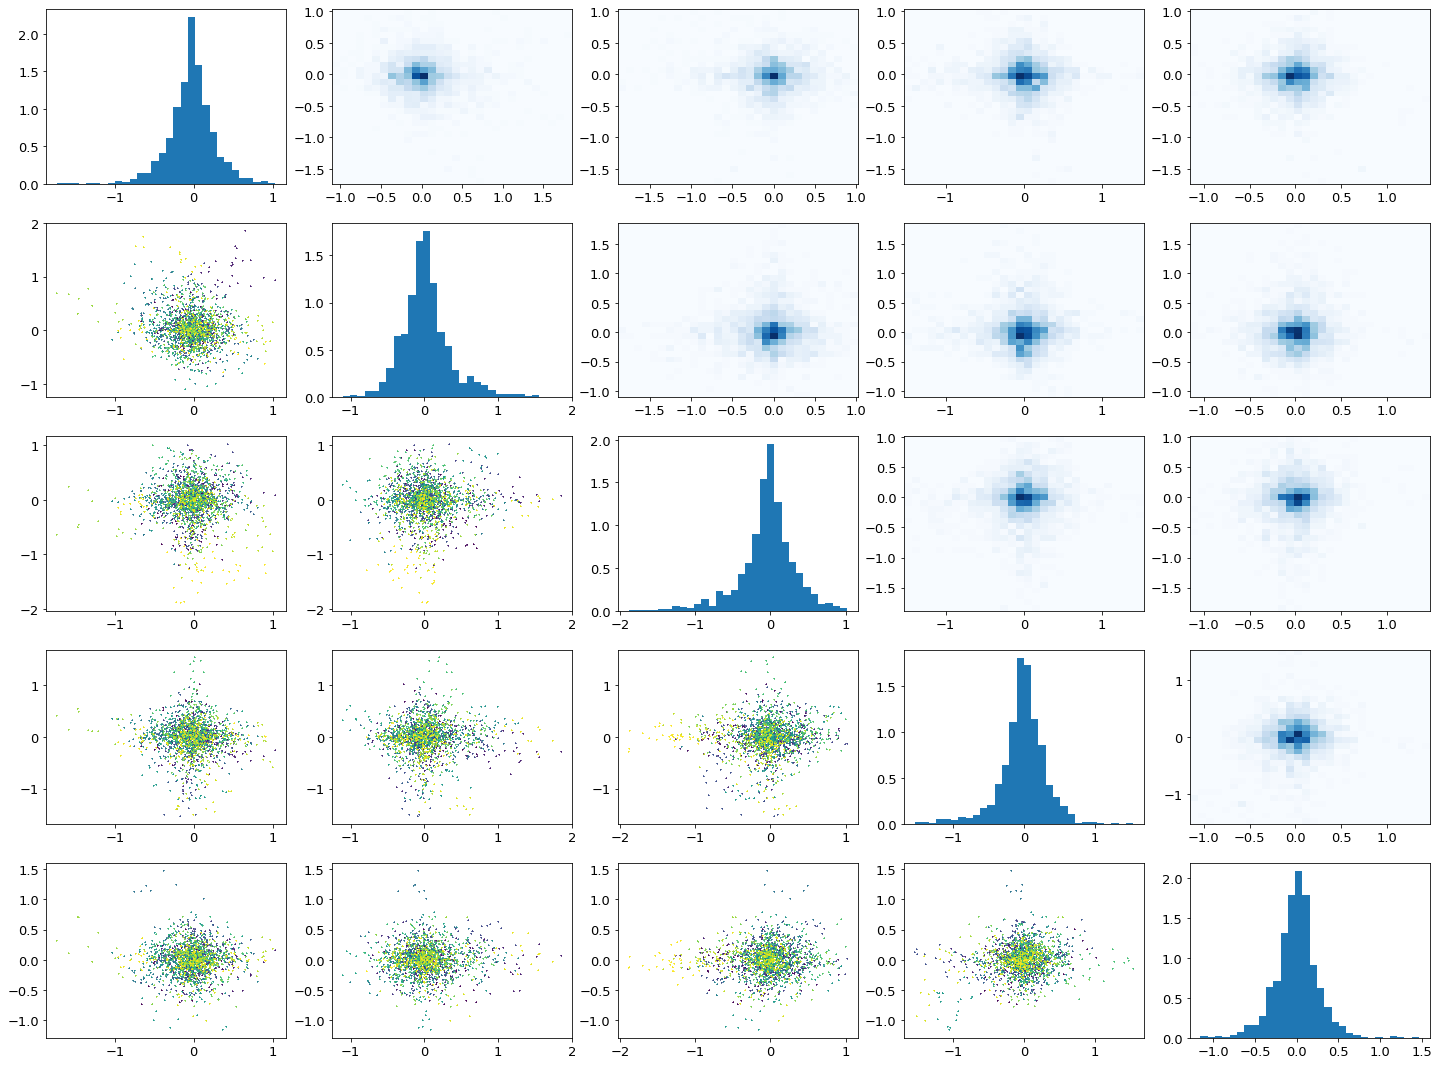

In [16]:
# plot parameters spread
fig, axs = plt.subplots(5, 5, figsize=(20, 15))
for i in range(axs.shape[0]):
    axs[i, i].hist(parameters[:, i], bins=30, density=True)
    for j in range(i):
        axs[i, j].scatter(parameters[:, j], parameters[:, i], s=1, marker="+", c=np.arange(parameters.shape[0]))
    for j in range(i + 1, axs.shape[0]):
        axs[i, j].hist2d(parameters[:, j], parameters[:, i], bins=30, cmap="Blues")
plt.tight_layout()
plt.show()

## Predictions

Let's now have a look at the computed predictions and uncertainties.

In [17]:
# Logging predictions in their respective dataframes
test['NEE_MAP'] = NEE_test_MAP
test['Reco_MAP'] = Reco_test_MAP
test['GPP_MAP'] = GPP_test_MAP
train['NEE_MAP'] = NEE_train_MAP
train['Reco_MAP'] = Reco_train_MAP
train['GPP_MAP'] = GPP_train_MAP

test['NEE_mean'] = mu_NEE_pred_test
test['Reco_mean'] = mu_Reco_pred_test
test['GPP_mean'] = mu_GPP_pred_test
train['NEE_mean'] = mu_NEE_pred_train
train['Reco_mean'] = mu_Reco_pred_train
train['GPP_mean'] = mu_GPP_pred_train

test['NEE_sigma'] = sigma_NEE_pred_test
test['Reco_sigma'] = sigma_Reco_pred_test
test['GPP_sigma'] = sigma_GPP_pred_test
train['NEE_sigma'] = sigma_NEE_pred_train
train['Reco_sigma'] = sigma_Reco_pred_train
train['GPP_sigma'] = sigma_GPP_pred_train

train_day = train.loc[train.APAR_label == 1,]
train_night = train.loc[train.APAR_label == 0,]
test_day = test.loc[test.APAR_label == 1,]
test_night = test.loc[test.APAR_label == 0,]

Usually the respiration gets the worst performance. I tried different model architectures and this seems to be the "best" one (even though it's far from optimal). I think 2 effects are conjugated here:

- The respiration has a lower amplitude than the GPP, thus the model primary focuses on the GPP as it's responsible for a larger part of the loss;
- The Laplace prior for the model parameters is enforcing too much sparsity, which harms the performances;

On the left, the entire training and testing sets are shown (it's not the best as they are quite large, I'll work on that). On the right the MAP estimates are plotted against the observed values.

The MAP estimate seems to capture the global trend, but is quite inaccurate. The uncertainty is so high that the predictions are almost unusable.

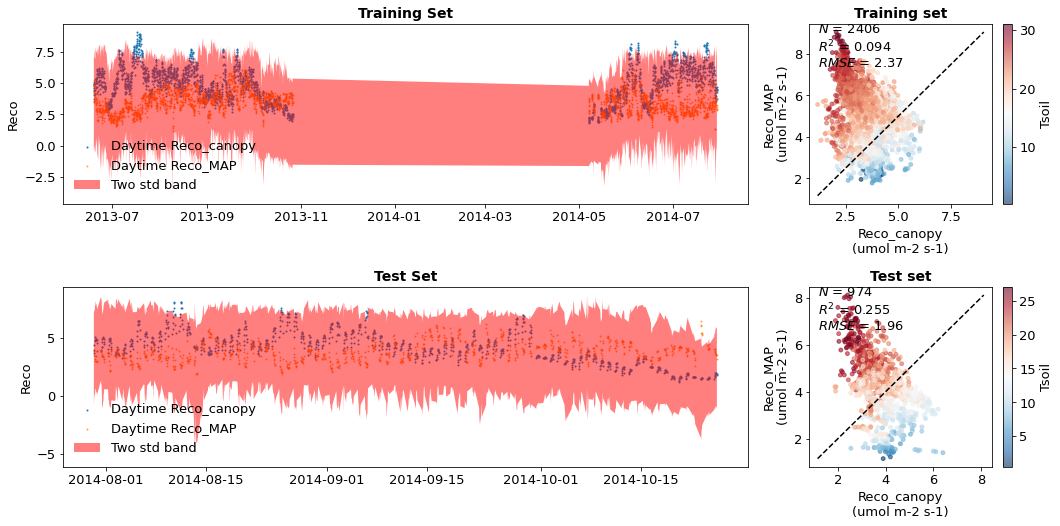

Ratio of training observations outside the 2σ band: 6.73e-02
Ratio of testing observations outside the 2σ band: 9.14e-03


In [18]:
fig, ax = quad_viz(train_day, test_day, "Reco", colors="Tsoil", unit="(umol m-2 s-1)")
print("Ratio of training observations outside the 2σ band: {r:.2e}".format(r=count_out_distribution(train_day, "Reco") / train_day.shape[0]))
print("Ratio of testing observations outside the 2σ band: {r:.2e}".format(r=count_out_distribution(test_day, "Reco") / train_day.shape[0]))

Results are much better for the GPP part. Again, the data sets are too large to have a nice time-series plot. But here, the MAP estimates are much more accurate, with a high $R^2$, and when zooming on the test set, the uncertainty seem to be completely reasonable.

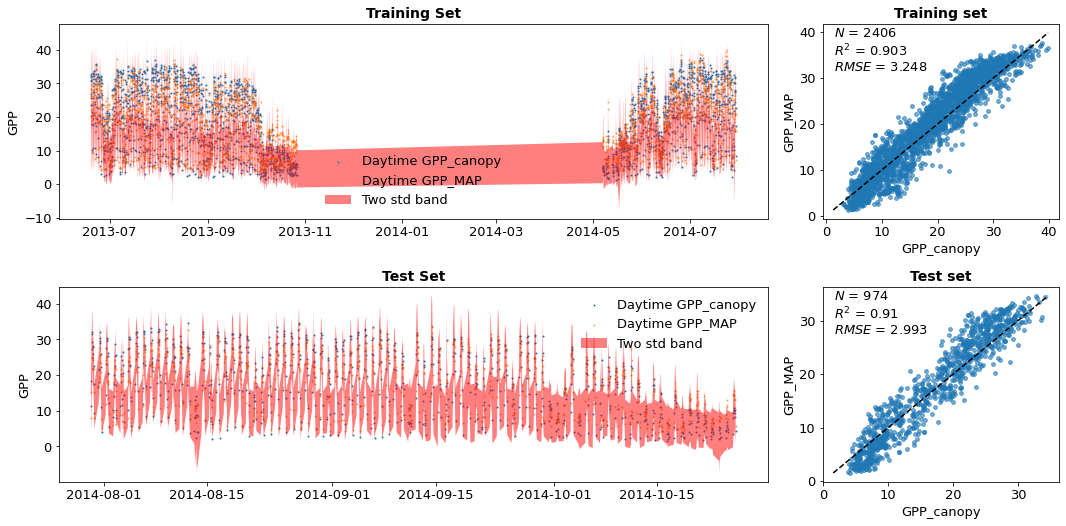

Ratio of training observations outside the 2σ band: 8.31e-04
Ratio of testing observations outside the 2σ band: 2.08e-03


In [19]:
fig, ax = quad_viz(train_day, test_day, "GPP")
print("Ratio of training observations outside the 2σ band: {r:.2e}".format(r=count_out_distribution(train_day, "GPP") / train_day.shape[0]))
print("Ratio of testing observations outside the 2σ band: {r:.2e}".format(r=count_out_distribution(test_day, "GPP") / train_day.shape[0]))

For control, here is the NEE trajectory. The performances are good overall, despite the poor results for Reco, which seems to confirm that the modeling choices are giving too much weight to GPP.

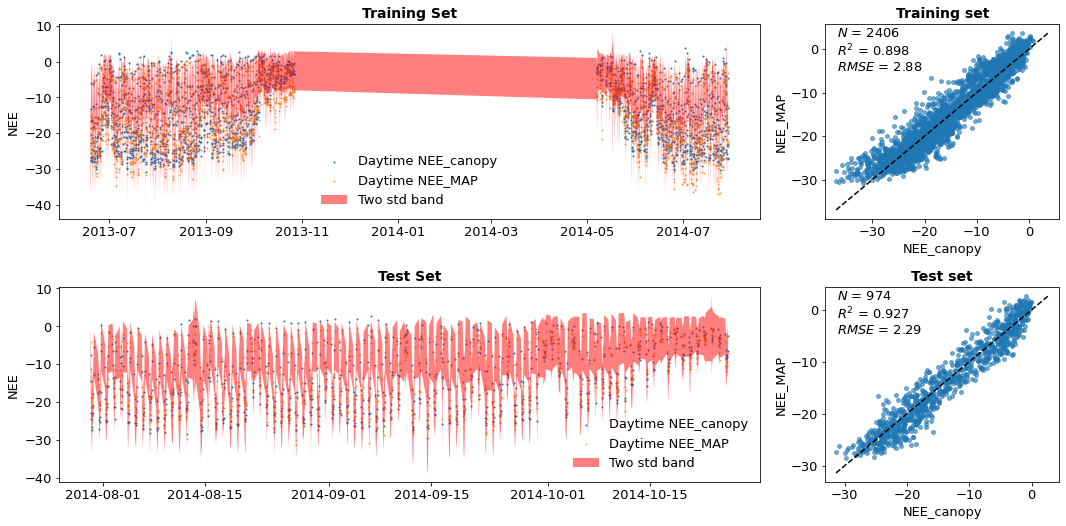

Ratio of training observations outside the 2σ band: 1.29e-02
Ratio of testing observations outside the 2σ band: 5.40e-03


In [20]:
fig, ax = quad_viz(train_day, test_day, "NEE")
print("Ratio of training observations outside the 2σ band: {r:.2e}".format(r=count_out_distribution(train_day, "NEE") / train_day.shape[0]))
print("Ratio of testing observations outside the 2σ band: {r:.2e}".format(r=count_out_distribution(test_day, "NEE") / train_day.shape[0]))

## $L_1$ regularization

At first, I thought that the Bayesian modeling was enforcing too much sparsity on the parameters. Thus, I tried to train a few NN models with different $L_1$ regularization. It is not as conclusive as I expected, but it's not enough to reject the hypothesis either.

Without any regularization, the predictions are much closer than our previous MAP estimate.

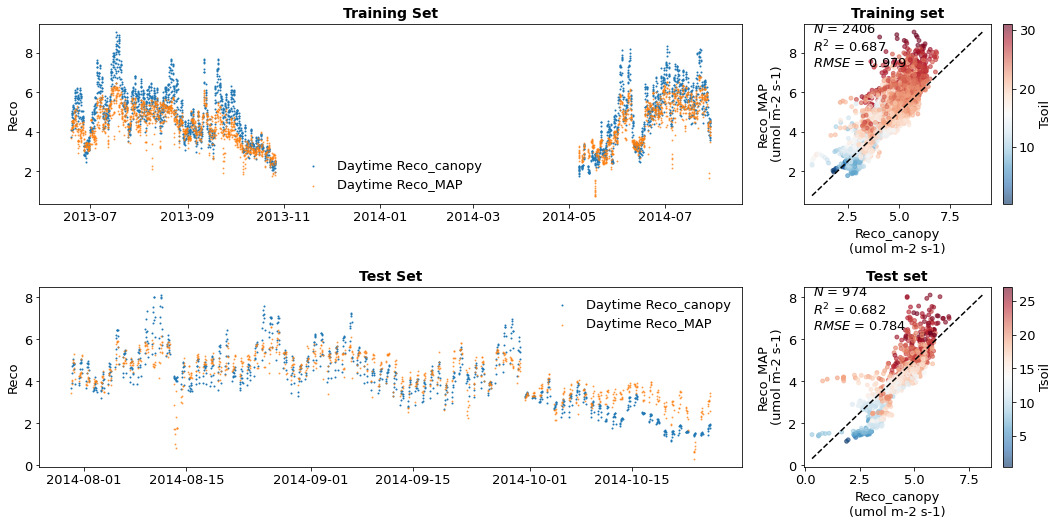

In [21]:
# GPP
APAR_input = Input(shape=(1,), dtype='float32', name='APAR_input')
EV_input1 = Input(shape=(EV1_train1.shape[1],), dtype='float32', name='EV_input1')
x = Dense(hidden_dim, activation="relu", name='hidden1_1')(EV_input1)
ln_GPP = Dense(1, activation=None, name='ln_GPP')(x)
GPP_1 = Lambda(lambda x: K.exp(x), name='GPP_1')(ln_GPP)
GPP = keras.layers.Multiply(name='GPP')([GPP_1, APAR_input])

# Reco
EV_input2 = Input(shape=(EV2_train1.shape[1],), dtype='float32', name='EV_input2')
x = Dense(hidden_dim, activation="relu", name='hidden2_1')(EV_input2)
x = Dense(hidden_dim, activation="relu", name='hidden2_2')(x)
ln_Reco = Dense(1, activation=None, name='ln_Reco')(x)
Reco = Lambda(lambda x: K.exp(x), name='Reco')(ln_Reco)

NEE = keras.layers.Subtract(name='NEE')([Reco, GPP])

model_NEE = Model(inputs=[APAR_input, EV_input1, EV_input2], outputs=[NEE])
model_NEE.compile(
    optimizer=keras.optimizers.Adam(2e-3),
    loss=keras.losses.MeanSquaredError()
)
model_NEE.fit({'APAR_input': label_train, 'EV_input1': EV1_train1, 'EV_input2': EV2_train1},
                             {'NEE': NEE_train1},
                             epochs=500,
                             batch_size=64,
                             callbacks=[earlyStopping],
                             validation_split=0.3,
                             verbose=0)
NEE_train_NN, GPP_train_NN, Reco_train_NN = fluxes_SIF_predict_noSIF(model_NEE, label_train, EV1_train1, EV2_train1, NEE_max_abs)
NEE_test_NN, GPP_test_NN, Reco_test_NN = fluxes_SIF_predict_noSIF(model_NEE, label_test, EV1_test1, EV2_test1, NEE_max_abs)
test['NEE_MAP'] = NEE_test_NN
test['Reco_MAP'] = Reco_test_NN
test['GPP_MAP'] = GPP_test_NN
train['NEE_MAP'] = NEE_train_NN
train['Reco_MAP'] = Reco_train_NN
train['GPP_MAP'] = GPP_train_NN
train_day = train.loc[train.APAR_label == 1,]
test_day = test.loc[test.APAR_label == 1,]
fig, ax = quad_viz(train_day, test_day, "Reco", colors="Tsoil", unit="(umol m-2 s-1)", bayesian=False)
None

With a weight of $10^{-4}$ on all the parameters, performance actually increases.

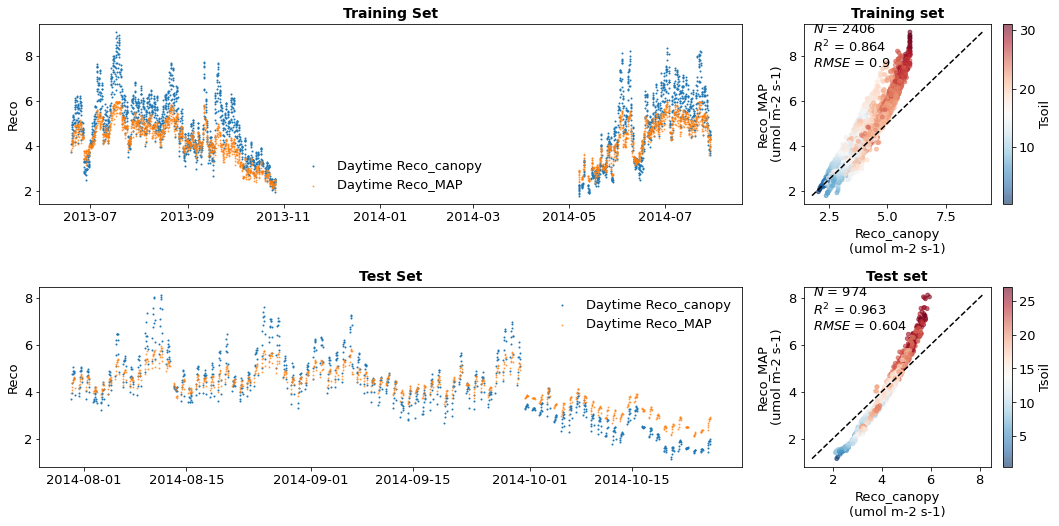

In [22]:
# GPP
APAR_input = Input(shape=(1,), dtype='float32', name='APAR_input')
EV_input1 = Input(shape=(EV1_train1.shape[1],), dtype='float32', name='EV_input1')
x = Dense(hidden_dim, activation="relu", name='hidden1_1', kernel_regularizer=tf.keras.regularizers.l1(1e-4), bias_regularizer=tf.keras.regularizers.l1(1e-4))(EV_input1)
ln_GPP = Dense(1, activation=None, name='ln_GPP')(x)
GPP_1 = Lambda(lambda x: K.exp(x), name='GPP_1')(ln_GPP)
GPP = keras.layers.Multiply(name='GPP')([GPP_1, APAR_input])

# Reco
EV_input2 = Input(shape=(EV2_train1.shape[1],), dtype='float32', name='EV_input2')
x = Dense(hidden_dim, activation="relu", name='hidden2_1', kernel_regularizer=tf.keras.regularizers.l1(1e-4), bias_regularizer=tf.keras.regularizers.l1(1e-4))(EV_input2)
x = Dense(hidden_dim, activation="relu", name='hidden2_2', kernel_regularizer=tf.keras.regularizers.l1(1e-4), bias_regularizer=tf.keras.regularizers.l1(1e-4))(x)
ln_Reco = Dense(1, activation=None, name='ln_Reco')(x)
Reco = Lambda(lambda x: K.exp(x), name='Reco')(ln_Reco)

NEE = keras.layers.Subtract(name='NEE')([Reco, GPP])

model_NEE = Model(inputs=[APAR_input, EV_input1, EV_input2], outputs=[NEE])
model_NEE.compile(
    optimizer=keras.optimizers.Adam(2e-3),
    loss=keras.losses.MeanSquaredError()
)
model_NEE.fit({'APAR_input': label_train, 'EV_input1': EV1_train1, 'EV_input2': EV2_train1},
                             {'NEE': NEE_train1},
                             epochs=500,
                             batch_size=64,
                             callbacks=[earlyStopping],
                             validation_split=0.3,
                             verbose=0)
NEE_train_NN, GPP_train_NN, Reco_train_NN = fluxes_SIF_predict_noSIF(model_NEE, label_train, EV1_train1, EV2_train1, NEE_max_abs)
NEE_test_NN, GPP_test_NN, Reco_test_NN = fluxes_SIF_predict_noSIF(model_NEE, label_test, EV1_test1, EV2_test1, NEE_max_abs)
test['NEE_MAP'] = NEE_test_NN
test['Reco_MAP'] = Reco_test_NN
test['GPP_MAP'] = GPP_test_NN
train['NEE_MAP'] = NEE_train_NN
train['Reco_MAP'] = Reco_train_NN
train['GPP_MAP'] = GPP_train_NN
train_day = train.loc[train.APAR_label == 1,]
test_day = test.loc[test.APAR_label == 1,]
fig, ax = quad_viz(train_day, test_day, "Reco", colors="Tsoil", unit="(umol m-2 s-1)", bayesian=False)
None

However, with more regularization ($> 3\times 10^{-4}$) the predictions become almost constant with value 4.

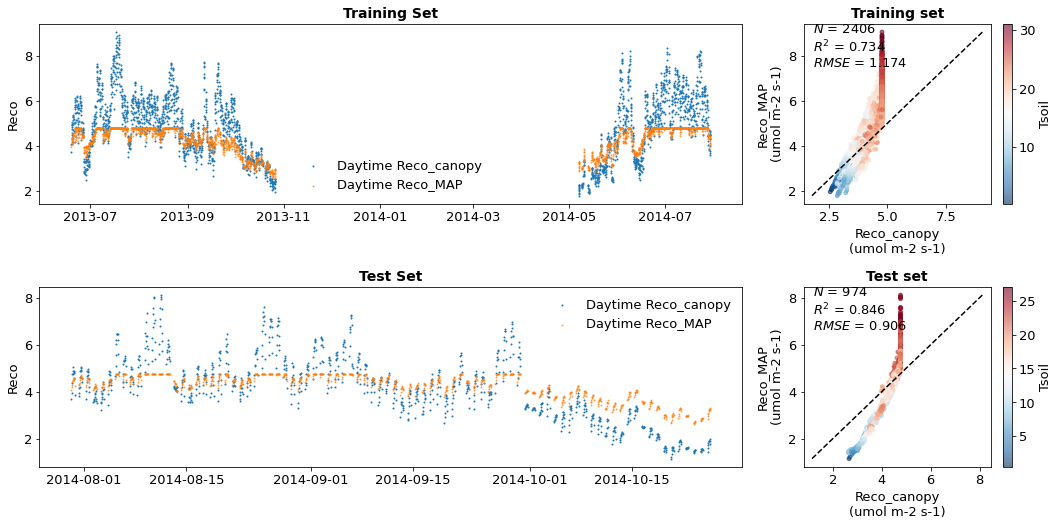

In [23]:
# GPP
APAR_input = Input(shape=(1,), dtype='float32', name='APAR_input')
EV_input1 = Input(shape=(EV1_train1.shape[1],), dtype='float32', name='EV_input1')
x = Dense(hidden_dim, activation="relu", name='hidden1_1', kernel_regularizer=tf.keras.regularizers.l1(3e-4), bias_regularizer=tf.keras.regularizers.l1(3e-4))(EV_input1)
ln_GPP = Dense(1, activation=None, name='ln_GPP')(x)
GPP_1 = Lambda(lambda x: K.exp(x), name='GPP_1')(ln_GPP)
GPP = keras.layers.Multiply(name='GPP')([GPP_1, APAR_input])

# Reco
EV_input2 = Input(shape=(EV2_train1.shape[1],), dtype='float32', name='EV_input2')
x = Dense(hidden_dim, activation="relu", name='hidden2_1', kernel_regularizer=tf.keras.regularizers.l1(3e-4), bias_regularizer=tf.keras.regularizers.l1(3e-4))(EV_input2)
x = Dense(hidden_dim, activation="relu", name='hidden2_2', kernel_regularizer=tf.keras.regularizers.l1(3e-4), bias_regularizer=tf.keras.regularizers.l1(3e-4))(x)
ln_Reco = Dense(1, activation=None, name='ln_Reco')(x)
Reco = Lambda(lambda x: K.exp(x), name='Reco')(ln_Reco)

NEE = keras.layers.Subtract(name='NEE')([Reco, GPP])

model_NEE = Model(inputs=[APAR_input, EV_input1, EV_input2], outputs=[NEE])
model_NEE.compile(
    optimizer=keras.optimizers.Adam(2e-3),
    loss=keras.losses.MeanSquaredError()
)
model_NEE.fit({'APAR_input': label_train, 'EV_input1': EV1_train1, 'EV_input2': EV2_train1},
                             {'NEE': NEE_train1},
                             epochs=500,
                             batch_size=64,
                             callbacks=[earlyStopping],
                             validation_split=0.3,
                             verbose=0)
NEE_train_NN, GPP_train_NN, Reco_train_NN = fluxes_SIF_predict_noSIF(model_NEE, label_train, EV1_train1, EV2_train1, NEE_max_abs)
NEE_test_NN, GPP_test_NN, Reco_test_NN = fluxes_SIF_predict_noSIF(model_NEE, label_test, EV1_test1, EV2_test1, NEE_max_abs)
test['NEE_MAP'] = NEE_test_NN
test['Reco_MAP'] = Reco_test_NN
test['GPP_MAP'] = GPP_test_NN
train['NEE_MAP'] = NEE_train_NN
train['Reco_MAP'] = Reco_train_NN
train['GPP_MAP'] = GPP_train_NN
train_day = train.loc[train.APAR_label == 1,]
test_day = test.loc[test.APAR_label == 1,]
fig, ax = quad_viz(train_day, test_day, "Reco", colors="Tsoil", unit="(umol m-2 s-1)", bayesian=False)
None

While it's a nice warning on the effect of over-regularization, predictions don't look anything like our previous MAP predictions. So we cannot conclude on the benefits of the sparsity brought by the Laplace prior.